In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(dpi=100, fontsize=15)

In [4]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

### Johnny's completeness map for detection

In [8]:
x = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness-x.txt')
y = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness-y.txt')
comp_map = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness.txt') / 100

In [537]:
from scipy.interpolate import interp2d

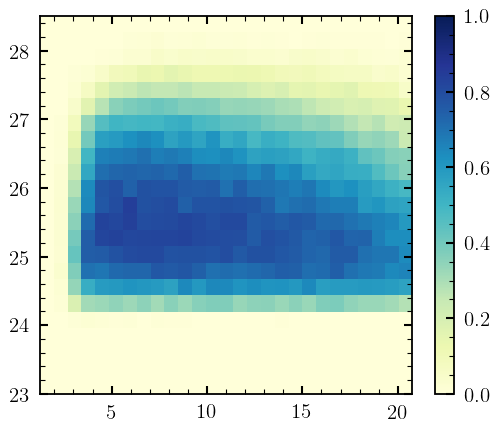

In [540]:
plt.imshow(comp_map, 
           extent=[min(x), max(x), min(y), max(y)], 
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.colorbar()

### Analyze mock gals

In [71]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')[:1000]
# old_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_vanillanosegmap.fits')
# old_seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_vanillasegmap.fits')

files = [
    f'./Catalog/mock_sample/_lsbg_meas_spergel_monotonic_spergel_{start}_{start+200}_nosegmap.fits' 
    for start in [0, 200, 400, 600, 800]] # , 1000, 1500
meas_cat = vstack([Table.read(file) for file in files])

files = [
    f'./Catalog/mock_sample/_lsbg_meas_spergel_monotonic_spergel_{start}_{start+200}_segmap.fits' 
    for start in [0, 200, 400, 600, 800]] # , 1000, 1500
seg_meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')[:1000]

# old_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_mea_spergel_nosegmap.fits')
# old_seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_mea_spergel_segmap.fits')
# params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
bad_flag |= (params_cat['SB_eff_g'] > 27.5)

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]
seg_meas_cat = seg_meas_cat[~bad_flag]

# old_meas_cat = old_meas_cat[~bad_flag]
# old_seg_meas_cat = old_seg_meas_cat[~bad_flag]

In [72]:
len(meas_cat)

769

In [10]:
udg_cat = Table.read(f'{TIGRESS}/Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits')

### Plot model param distribution

In [11]:
from scipy.stats import binned_statistic_2d

In [12]:
bin_num = [10, 10]
_range = [[1, 10], [24, 29]]

In [13]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range, 
    expand_binnumbers=False)

In [14]:
res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=[bin_num, bin_num],
    range=_range, 
    expand_binnumbers=False)

ValueError: The smallest edge difference is numerically 0.

In [82]:
ratio_set = []
for i in range((bin_num + 2)**2):
    ratio_set.append(np.sum(np.in1d(
        params_cat[res_truth.binnumber == i]['viz-id'].data, 
        params_cat[res_meas.binnumber == i]['viz-id'].data)) / len(
        params_cat[res_truth.binnumber == i]['viz-id'].data))

TypeError: can only concatenate list (not "int") to list

In [313]:
ratio_set = np.array(ratio_set).reshape(bin_num + 2, bin_num + 2).T
ratio_set = ratio_set[1:-1, 1:-1]

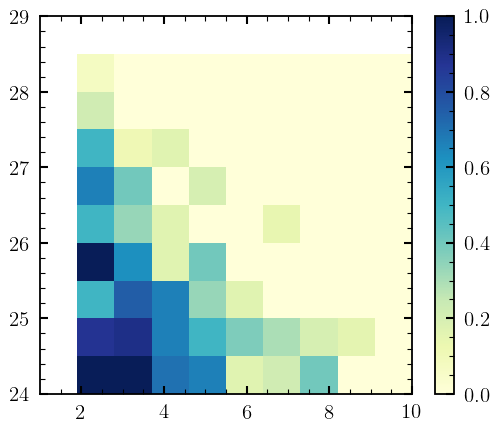

In [315]:
plt.imshow(ratio_set, 
           extent=[item for sublist in _range for item in sublist],
           vmin=0, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

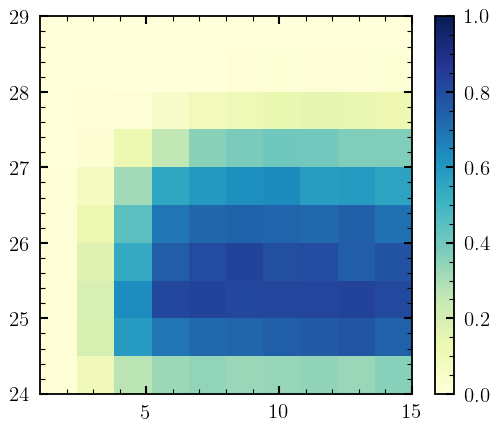

In [316]:
plt.imshow(f((res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
             (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2) / 100, 
           extent=[1, 15, 24, 29],
           vmin=0, vmax=1, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

In [317]:
mat = f((res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
             (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2) / 100
mat *= ratio_set

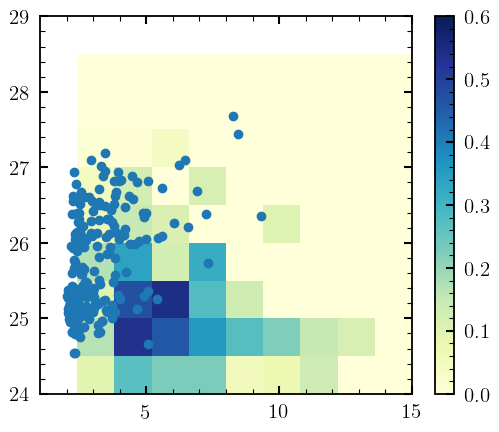

In [320]:
plt.imshow(mat,
           extent=[1, 15, 24, 29],
           vmin=0, vmax=0.6, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

plt.scatter(udg_cat['rhalf_circularized'].data * 0.168, 
            udg_cat['SB_eff_avg'][:, 0].data)

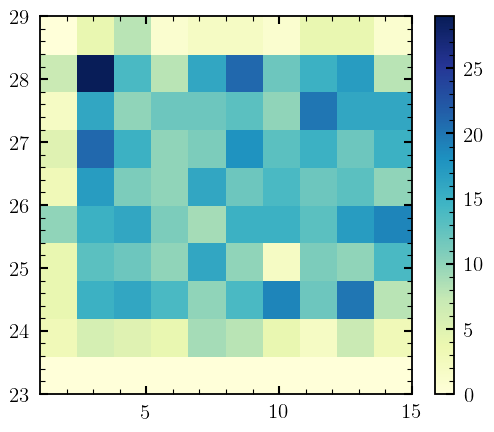

In [123]:
(h_truth, x_edges, y_edges, _) = plt.hist2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    bins=[10, 10],
    range=[[1, 15], [23, 29]],
    vmin=0,
    cmap='YlGnBu',
    )
plt.colorbar()

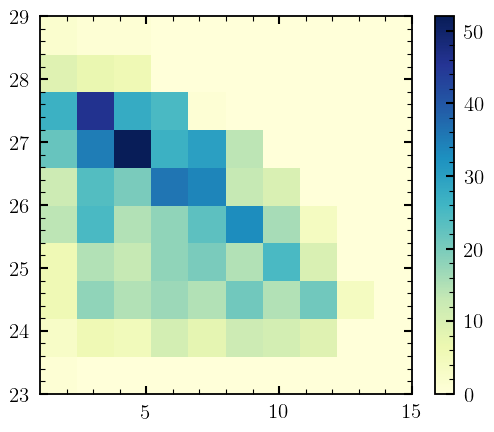

In [124]:
(h_meas, x_edges, y_edges, _) = plt.hist2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    bins=[10, 10],
    range=[[1, 15], [23, 29]],
    vmin=0,
    cmap='YlGnBu',
    )
plt.colorbar()

In [125]:
ratio = h_meas / h_truth
ratio = np.nan_to_num(ratio, 0, posinf=0)

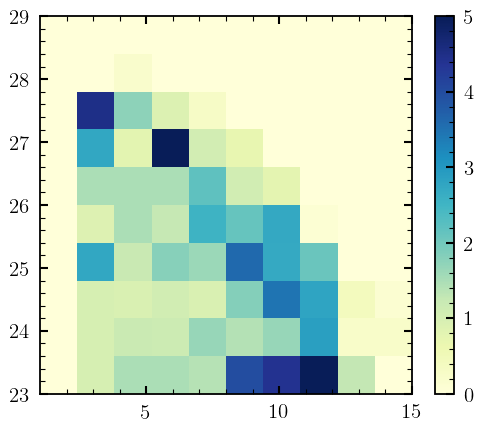

In [127]:
plt.imshow(ratio, 
           extent=[1, 15, 23, 29],
           vmin=0, vmax=5, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

Text(0, 0.5, '$R_e$ [measure]')

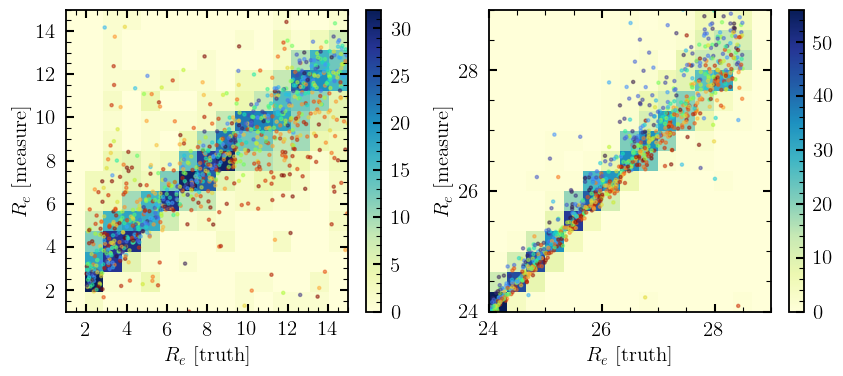

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axes[0])
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
#* np.sqrt(1 - meas_cat['ell_sym'].data)
re_truth =  params_cat['rhalf_circularized'].data# * np.sqrt(1 - params_cat['ellip'].data)
# params_cat['rhalf_circularized'].data
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data


(h_re, x_edges, y_edges, im) = plt.hist2d(
    re_truth, re_meas,
    bins=[15, 15],
    range=[[1, 15], [1, 15]],
    cmap='YlGnBu',
    )
plt.scatter(re_truth, re_meas, c=SB_truth, s=5, alpha=0.5)
# plt.axes().set_aspect('equal')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(im)
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')


plt.sca(axes[1])
(h_re, x_edges, y_edges, im) = plt.hist2d(
    SB_truth, SB_meas,
    bins=[15, 15],
    range=[[24, 29], [24, 29]],
    cmap='YlGnBu',
    )
plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
# plt.axes().set_aspect('equal')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.colorbar(im)
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')

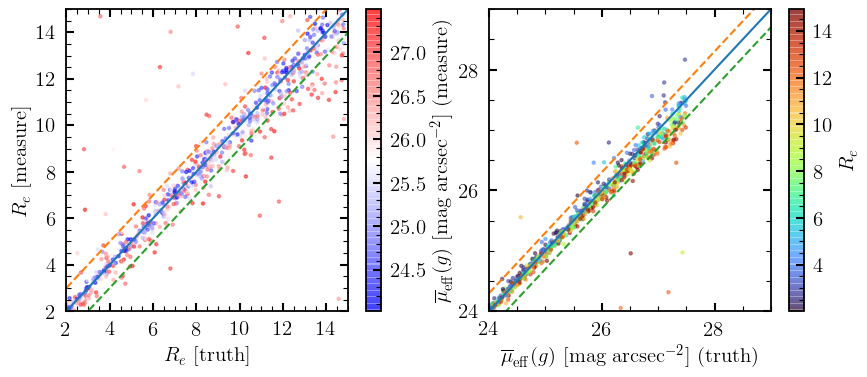

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

re_meas = meas_cat['rhalf_spergel'].data * 0.168 
re_truth =  params_cat['rhalf_circularized'].data
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)
plt.subplots_adjust(wspace=0.2)

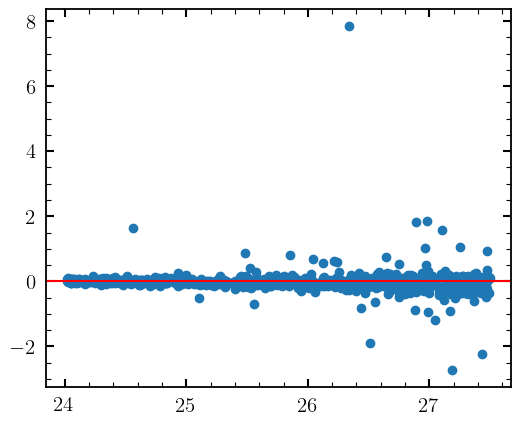

In [74]:
plt.scatter(params_cat['SB_eff_g'], params_cat['mag_g'] - meas_cat['mag'].data[:, 0], )

plt.axhline(0, c='r')

(-1.0, 1.0)

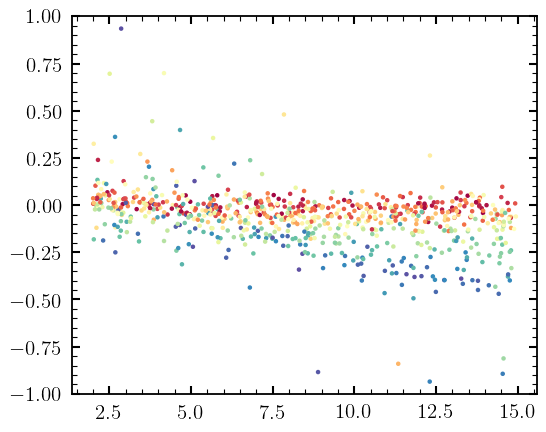

In [75]:
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, (re_meas - re_truth) / re_truth, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)

plt.ylim(-1, 1)

(2.0, 15.0)

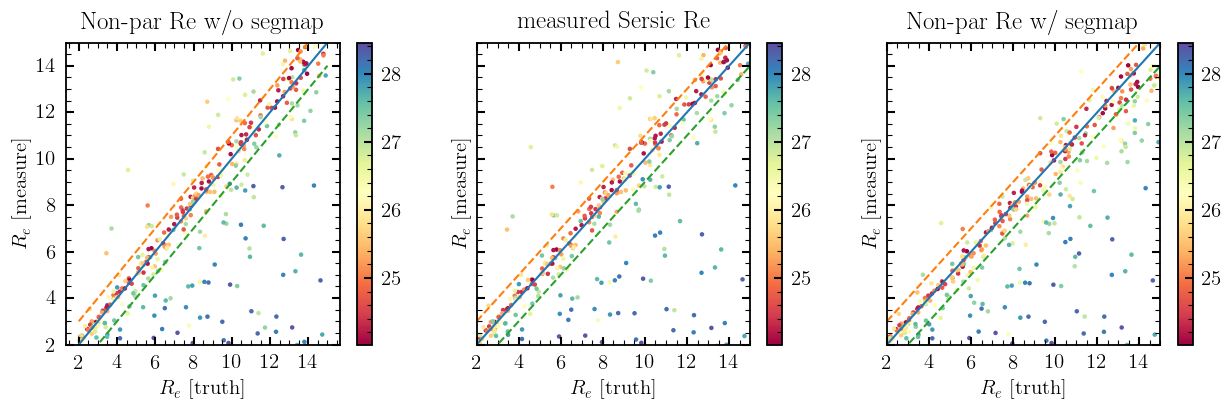

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

re_truth = params_cat['rhalf_circularized'].data
SB_truth = params_cat['SB_eff_g'].data

plt.sca(axes[0])
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('Non-par Re w/o segmap')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
# plt.xlim(2, 15)
# plt.ylim(2, 15)

plt.sca(axes[1])
re_meas = meas_cat['sersic_rhalf'].data * 0.168 * np.sqrt(1 - seg_meas_cat['ell_sym'].data)
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('measured Sersic Re')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

plt.sca(axes[2])
re_meas = seg_meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('Non-par Re w/ segmap')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [29]:
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
re_truth = params_cat['rhalf_circularized'].data

(16.0, 25.0)

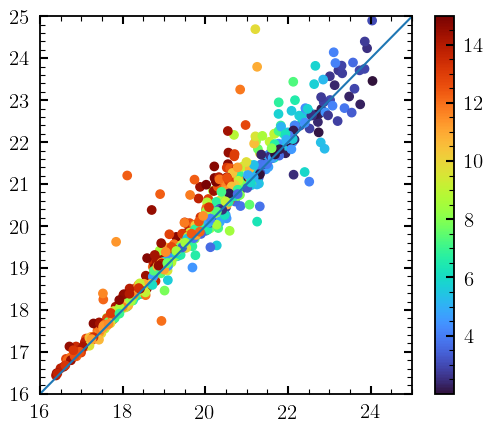

In [73]:
plt.scatter(params_cat['mag_g'], 
            -2.5 * np.log10(meas_cat['flux_circ'][:, 0]) + 27.0, 
            c=re_truth)
plt.colorbar()
x = np.linspace(16, 25)
plt.plot(x, x)

plt.xlim(16, 25)
plt.ylim(16, 25)

In [75]:
ind = 12
re_meas[meas_cat['ID'] == ind], re_truth[meas_cat['ID'] == ind]

(array([13.00147788]), array([6.60513883]))

In [422]:
params_cat[meas_cat['ID'] == 420]

<Table length=1>
viz-id      SB_eff_g      ...         g-r         rhalf_circularized
int64       float64       ...       float64            float64      
------ ------------------ ... ------------------- ------------------
   420 27.562105696766316 ... 0.47499725494297956  4.080324174021523

In [ ]:
# 1254 is too large
# Large: 1245

In [6]:
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
re_truth = params_cat['rhalf_circularized'].data

In [7]:
bad_ids = params_cat[abs(re_meas - re_truth) > 3][['viz-id', 'SB_eff_g', 'rhalf_circularized']]['viz-id'].data
bad_ids

array([1605, 1609, 1616, 1622, 1623, 1634, 1639, 1641, 1652, 1660, 1665,
       1671, 1675, 1706, 1715, 1718, 1728, 1729, 1732, 1741, 1744, 1748,
       1750, 1754, 1757, 1769, 1771, 1775, 1776, 1779, 1781, 1783, 1791,
       1801, 1803, 1823, 1838, 1853, 1860, 1865, 1872, 1873, 1875, 1876,
       1877, 1881, 1892, 1904, 1906, 1907, 1911, 1920, 1927, 1944, 1949,
       1955, 1959, 1981])

In [8]:
params_cat[np.in1d(params_cat['viz-id'], bad_ids)]

<Table length=58>
viz-id      SB_eff_g      ...         g-r          rhalf_circularized
int64       float64       ...       float64             float64      
------ ------------------ ... -------------------- ------------------
  1605 26.335769059087216 ...   0.4507060612927778 4.3768911382946225
  1609 26.430053615720297 ...   0.5281084332900203  14.60904482948748
  1616 28.473627125495256 ...   0.3179126228247395  9.238203842066444
  1622 26.530335671450594 ...   0.3768569307704689  4.836697949178239
  1623  28.30931378027421 ...   0.4884758350032699 13.362933052967406
  1634 28.172300187657537 ...  0.11876206871864818 3.2190948413412146
  1639  28.17150435565933 ...    0.514369823797734  4.698032170674145
  1641 27.789149824693894 ...   0.5372148093250249 13.809649174431879
  1652 25.184006564598793 ...   0.6169093418485487  12.75818967956261
  1660  26.70267450012278 ...   0.3314347358425589   8.62810212415595
   ...                ... ...                  ...                ...
  1906  28.31133066053721 ...   0.2694197301413928  8.683240753166377
  1907  25.65573338085938 ...  0.44738136458428124  6.010087659363292
  1911 27.944928428226902 ...    0.279679015794386  5.535981869476629
  1920  27.13028165923563 ...   0.4344052777092202 14.307831180999129
  1927 26.164378004487556 ...   0.4983405019018915 10.573577761467252
  1944  27.54876734102583 ...   0.3828258746389525  3.303192328397396
  1949  25.95308714778244 ...   0.3019757422435692  5.039566830209834
  1955  28.19900999104601 ...  0.44420626934900737 13.289323811310142
  1959 27.535432281361043 ...   0.6874188612539094  2.512093838006652
  1981   27.6118948940807 ... 0.014958732066593445 12.473434469723445

In [19]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 2.0 / 0.168)# & (meas_cat['rhalf_circularized'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0)

mask &= (meas_cat['ell_sym'] < 0.65)

# mask &= (meas_cat['M20'] < -1.1)
# mask &= (meas_cat['Gini'] < 0.7)
# mask &= ~((meas_cat['M20'] < -1.6) & (
#     meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
#mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)

# mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

In [20]:
bin_num = [15, 15]
_range = [[1, 12], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

In [21]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_truth_cuts = binned_statistic_2d(
    params_cat['rhalf_circularized'].data[mask],
    params_cat['SB_eff_g'].data[mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas_cuts = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data[mask] * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0][mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

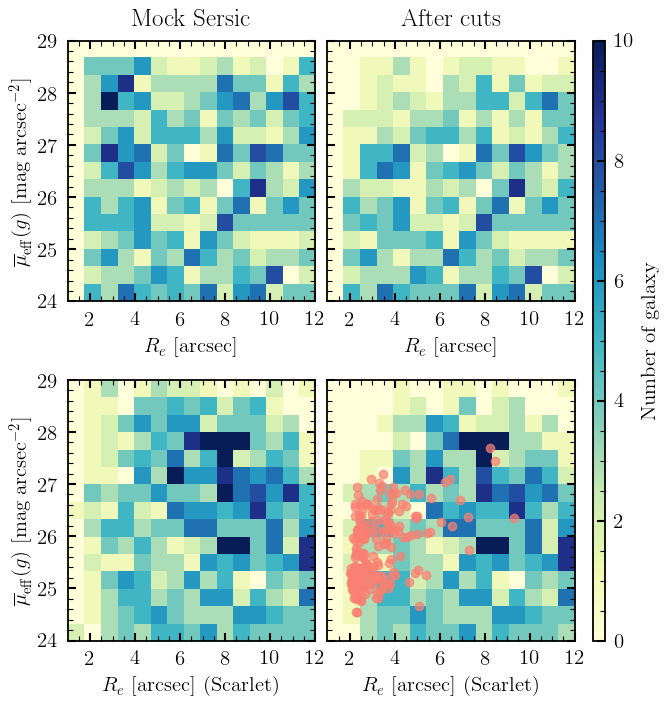

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=False)

# In original size
plt.sca(axes[0, 0])
plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

plt.sca(axes[0, 1])
plt.imshow(res_truth_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

# In measured size
plt.sca(axes[1, 0])
plt.imshow(res_meas.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

plt.sca(axes[1, 1])
im = plt.imshow(res_meas_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')
for ax in axes[1]:
    ax.set_xlabel(r'$R_e$ [arcsec] (Scarlet)')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

axes[0, 0].set_title('Mock Sersic')
axes[0, 1].set_title('After cuts')


# # CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Number of galaxy')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

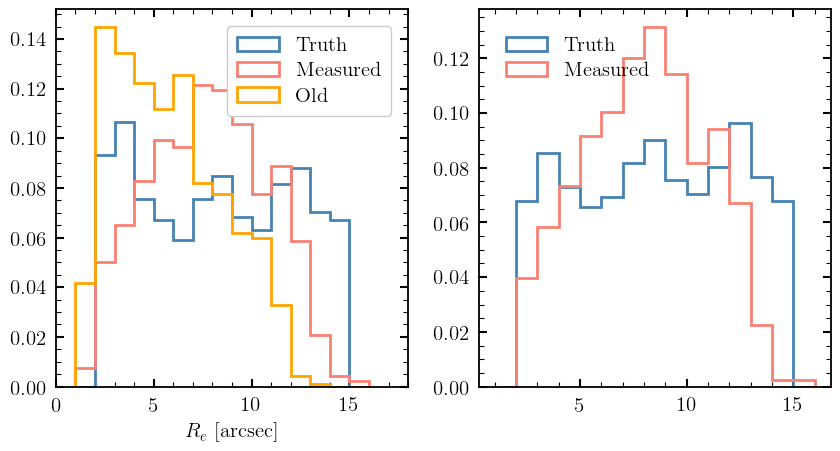

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axes[0])
plt.hist(params_cat['rhalf_circularized'].data,
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='steelblue', 
         label='Truth', density=True)
plt.hist(meas_cat['rhalf_circularized'].data * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='salmon', 
         label='Measured',density=True)
plt.hist(old_meas_cat['rhalf_circularized'].data * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='orange', 
         label='Old',density=True)
plt.legend(frameon=True)
plt.xlabel(r'$R_e$ [arcsec]')
plt.xlim(0, 18)

plt.sca(axes[1])
plt.hist(params_cat['rhalf_circularized'].data[mask],
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='steelblue', 
         label='Truth', density=True)
plt.hist(meas_cat['rhalf_circularized'].data[mask] * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='salmon', 
         label='Measured',density=True)
plt.legend(loc='upper left')

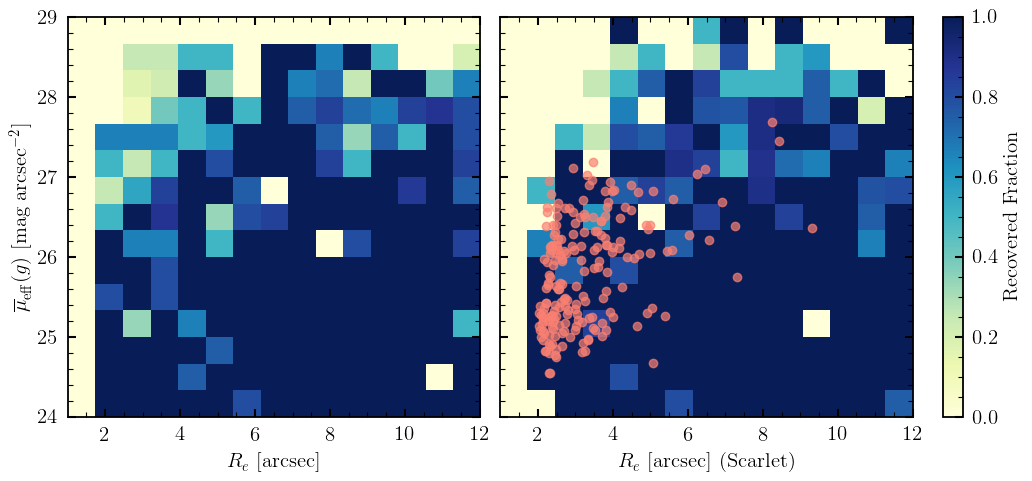

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
im = plt.imshow(np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

plt.sca(axes[1])
im = plt.imshow(np.nan_to_num(res_meas_cuts.statistic.T / res_meas.statistic.T, 0, posinf=0),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)


for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))

axes[0].set_xlabel(r'$R_e$ [arcsec]')
axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[1].set_xlabel(r'$R_e$ [arcsec] (Scarlet)')

## CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [26]:
im = plt.imshow(
    np.nan_to_num(res_meas_cuts.statistic.T / res_meas.statistic.T, 
                  0, posinf=0) * f(
        (res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
        (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

plt.colorbar(im)

NameError: name 'f' is not defined

In [30]:
ddre_meas_ser = (meas_cat['sersic_rhalf'] * np.sqrt(1 - seg_meas_cat['ell_sym']) * 0.168)

In [ ]:
# Large stuff: 5, 14, 15, 21, 26, 29, 31, 40

In [30]:
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
re_truth = params_cat['rhalf_circularized'].data

In [31]:
bad_ids = params_cat[abs(re_meas - re_truth) > 3.5][['viz-id', 'SB_eff_g', 'rhalf_circularized']]['viz-id'].data
bad_ids

array([  1,   7,  30,  33,  34,  45,  50,  53,  55,  65,  69,  73,  87,
        88,  91, 104, 113, 121, 134, 139, 140, 142, 150, 159, 165, 170,
       178, 186, 191, 192, 197, 198, 210, 214, 216, 226, 228, 230, 240,
       242, 245, 247, 248, 251, 256, 260, 261, 263, 271, 272, 276, 280,
       293, 305, 322, 324, 344, 351, 355, 358, 363, 364, 373, 383, 389,
       390, 391, 399])

In [23]:
meas_cat[meas_cat['ID'] == 399]['rhalf_circularized'] * 0.168

<Column name='rhalf_circularized' dtype='float64' length=0>

In [50]:
params_cat[np.in1d(params_cat['viz-id'], bad_ids)][:]

<Table length=68>
viz-id      SB_eff_g      ...         g-r         rhalf_circularized
int64       float64       ...       float64            float64      
------ ------------------ ... ------------------- ------------------
     1 28.278214378844623 ...  0.5820417622052264  5.210724387935998
     7  27.89779265598721 ... 0.41607662906468235 12.097237240417355
    30  26.73395183355647 ...  0.3624471845441797  4.575269225876622
    33     28.26998491764 ... 0.44341878822466946 14.636069285209983
    34 28.345344148835515 ...  0.4876193942576598  9.910854545054065
    45  26.98135027959292 ...  0.6076620988478756 11.396585941710288
    50 28.363130824940512 ... 0.24333718330705667  7.957908339872534
    53  28.02672307692442 ...  0.4157327717372746  14.29407591100367
    55 28.148434057604025 ... 0.17699589831024404 10.697290385278409
    65 26.442132374212118 ... 0.10928161082791969  12.22161659199243
   ...                ... ...                 ...                ...
   355  26.89088675192842 ...  0.6844982763732025  3.567259413247973
   358  28.23103608641231 ...   0.605820484907153  8.941577143120929
   363  26.45527555192171 ... 0.31642013057789614  8.318006419368839
   364 28.236591639494364 ...  0.2150485733516262   9.50359852754916
   373 27.073530480373606 ...  0.5558338777580603  7.589104006071926
   383 27.948624060871737 ...  0.4498779992863342  7.602807866672851
   389 27.630756326702688 ...  0.3276445583183419 10.949265240397779
   390  28.45727313900303 ...  0.4026180904303324  6.869187531261577
   391 25.856779546101418 ...  0.4817136175389325  4.169182622083786
   399  27.39544293338107 ... 0.38180836794466094 10.279730126911662

315 is a good test case

In [47]:
ind = 355

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

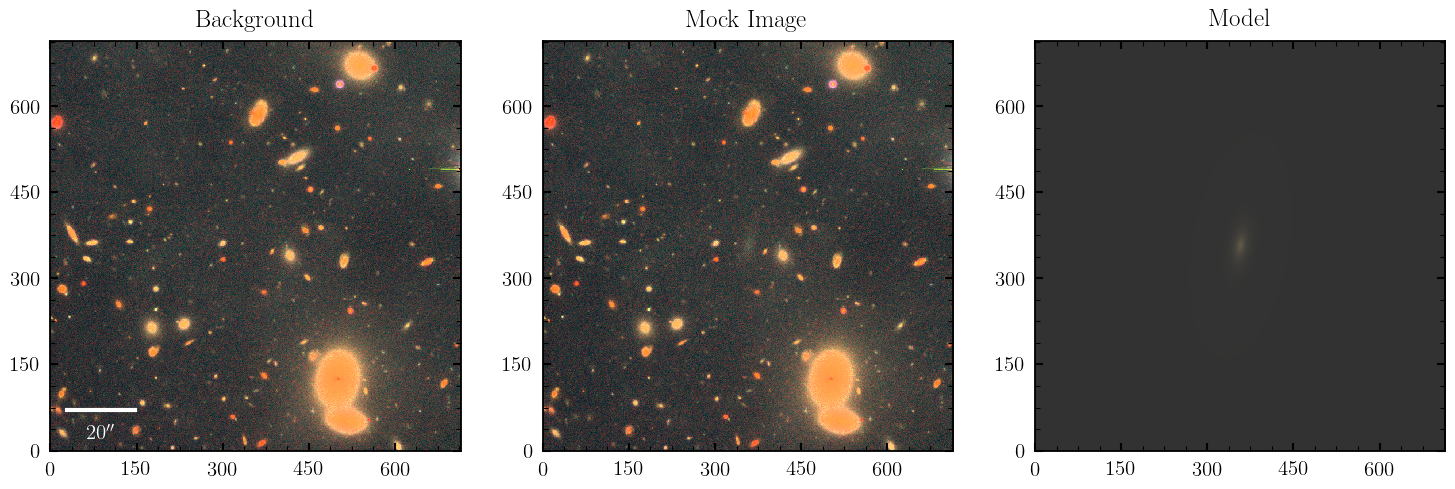

In [48]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display()

In [210]:
import statmorph
from kuaizi.detection import vanilla_detection

In [333]:
cat, segmap = vanilla_detection(gal.mock.images[0], sigma=2, convolve=True, conv_radius=2, show_fig=False)

    Detected 386 objects


In [334]:
segmap[segmap != segmap[segmap.shape[1] // 2, segmap.shape[0] // 2]] =  0
segmap[segmap != 0] = 1.

In [335]:
from astropy.convolution import convolve, Gaussian2DKernel

In [336]:
segmap = (convolve(segmap.astype(float), Gaussian2DKernel(15)) > 0.005).astype(float)

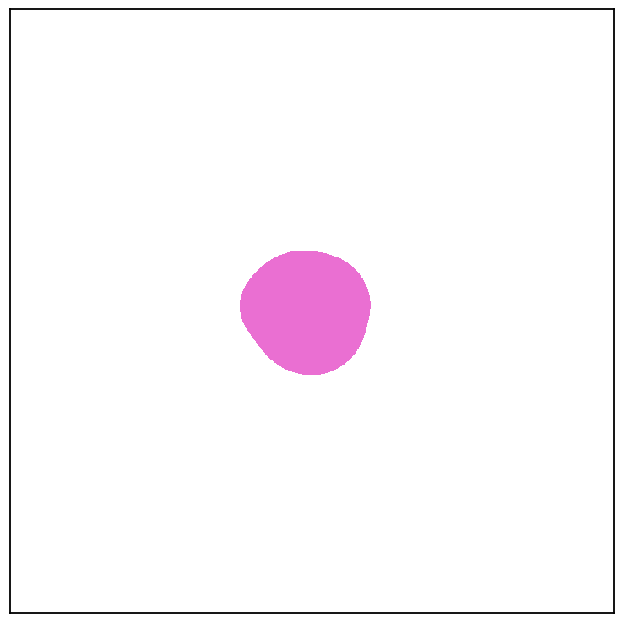

In [274]:
display_single(segmap, cmap=SEG_CMAP, scale='linear');

In [337]:
sky = np.zeros_like(gal.bkg.images)
for i in range(len(sky)):
    bkg = sep.Background(gal.bkg.images[i])
    sky[i] = np.random.normal(0, scale=np.sqrt(gal.bkg.variances)[i], size=(gal.bkg.images[i].shape))
#     sky[i] = np.random.normal(
#         0, scale=bkg.globalrms, size=(gal.bkg.images[i].shape))

In [332]:
segmap = np.ones_like(segmap, dtype=int)

In [338]:
source_morphs = statmorph.source_morphology(
        gal.model.images[0] + sky[0], segmap.astype(bool), weightmap=np.sqrt(1 / gal.bkg.variances)[0],
        n_sigma_outlier=15, cutout_extent=2,
        mask=~segmap.astype(bool), psf=None)
morph = source_morphs[0]

In [339]:
morph.rhalf_circ * 0.168, morph.sersic_rhalf * 0.168

(6.275735486198748, 9.562424229456756)

In [340]:
-2.5 * np.log10(morph.flux_circ) + 27

20.857621487281598

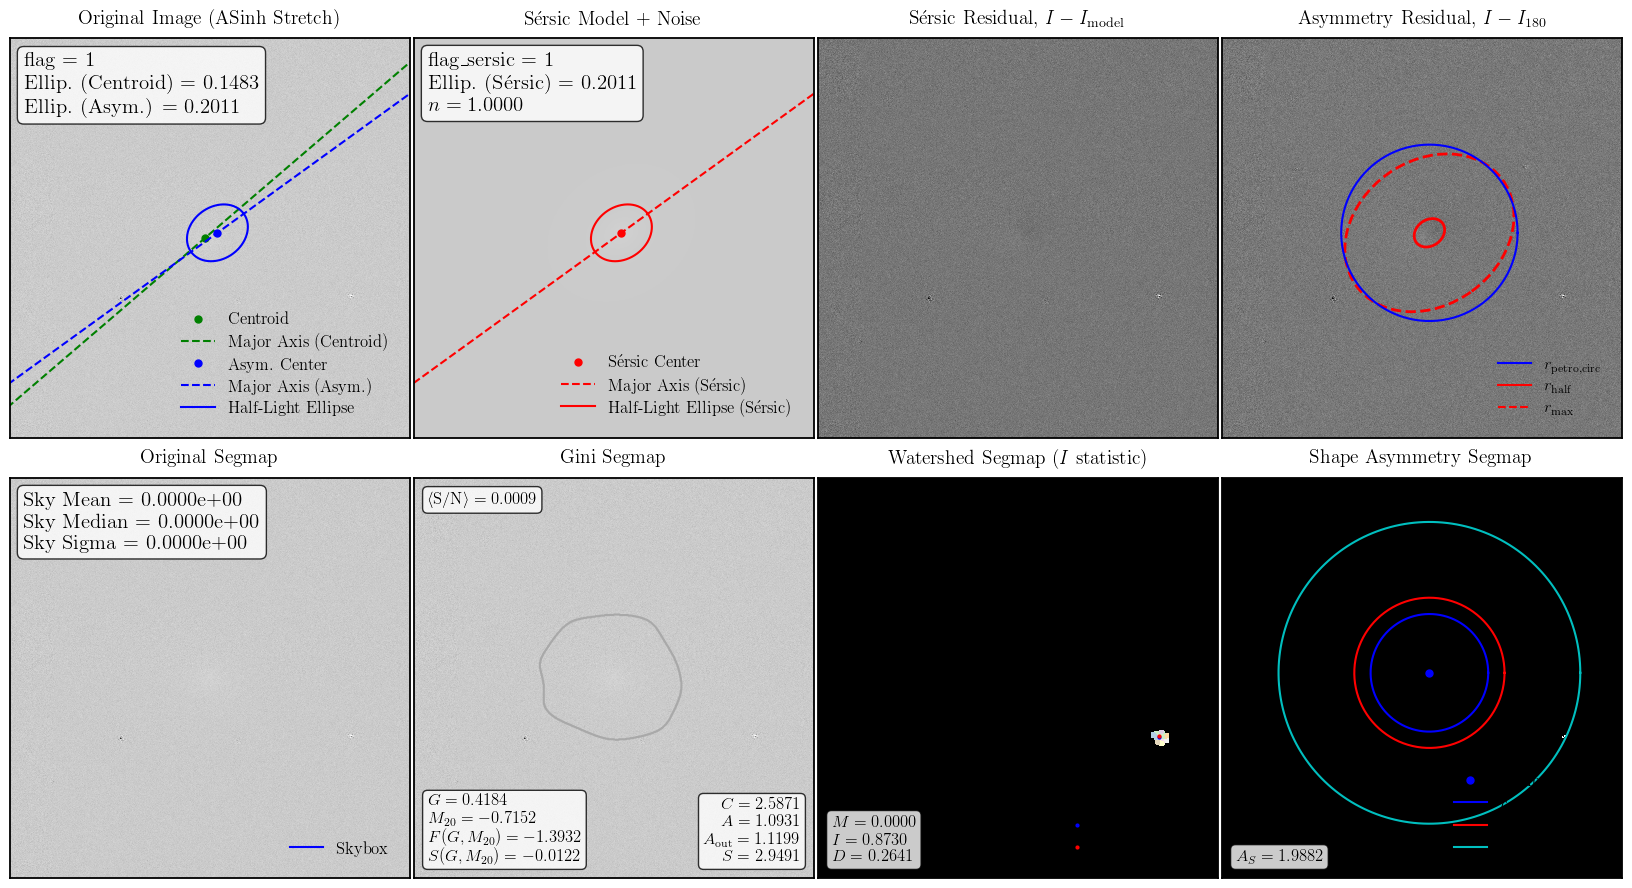

In [326]:
fig = statmorph.utils.image_diagnostics.make_figure(source_morphs[0])

In [113]:
import sep
from kuaizi.display import display_rgb

In [191]:
sky = np.zeros_like(gal.bkg.images)
for i in range(len(sky)):
    bkg = sep.Background(gal.bkg.images[i])
    sky[i] = np.random.normal(0, scale=0.001 * bkg.globalrms, size=(gal.bkg.images[i].shape))
#     sky[i] = np.random.poisson(bkg.globalrms**3, size=(gal.bkg.images[i].shape))

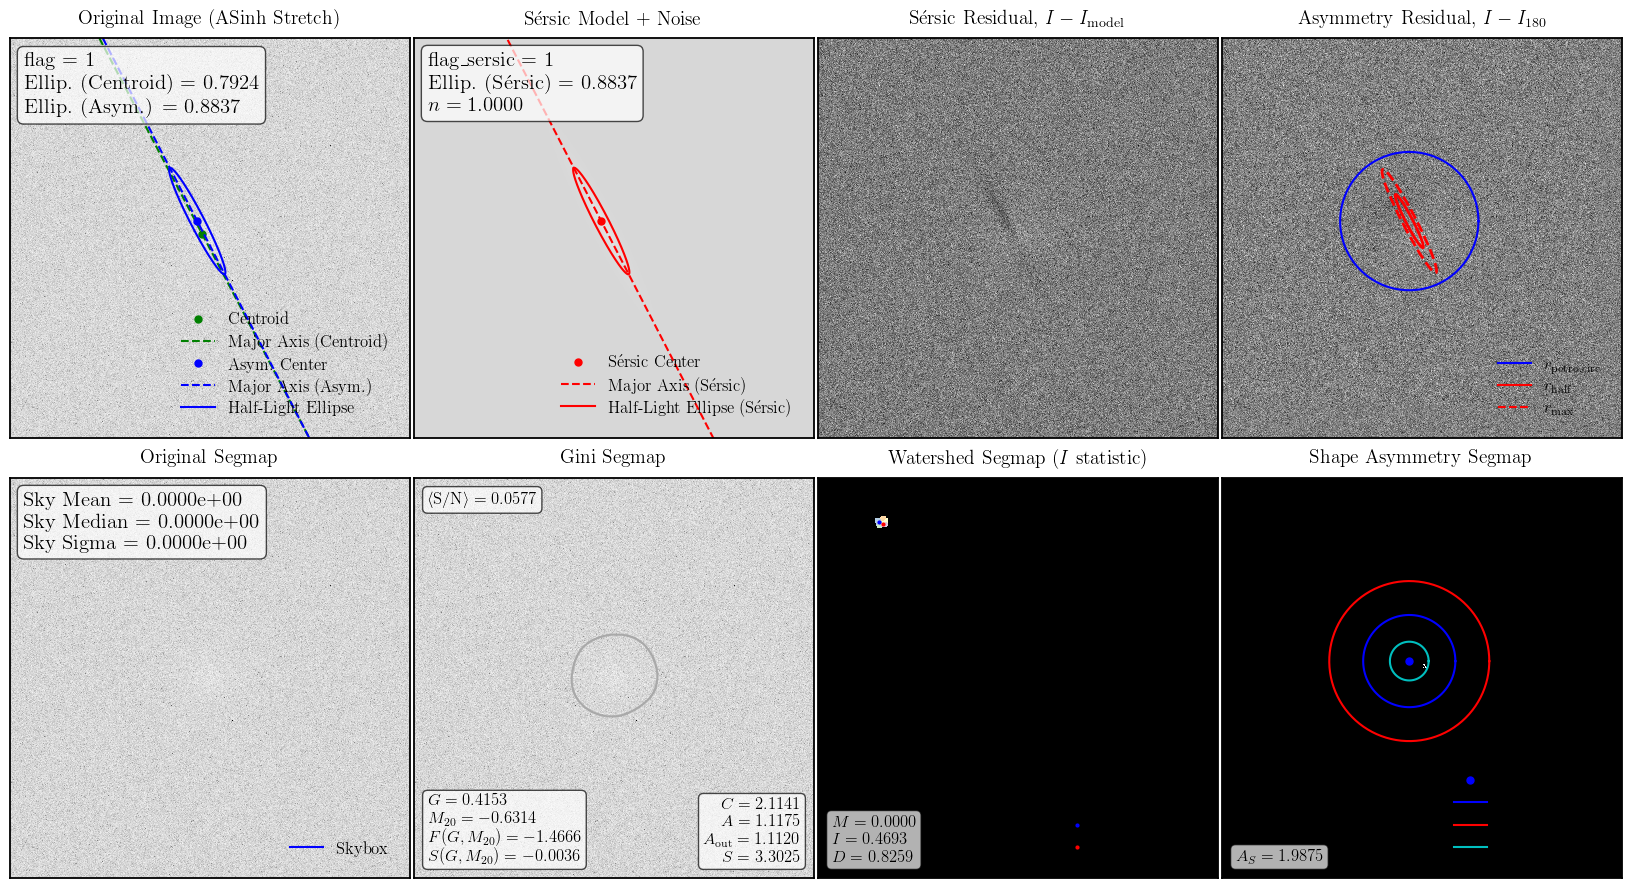

In [202]:
measurement, t = makeMeasurementMockGal(gal,
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)

In [203]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])

6.128634135141055
9.038298895518608


In [24]:
import dill
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

In [25]:
ind = 0

In [52]:
method = 'spergel'
# method = 'vanilla'
with open(f'./Model/mock_sample/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0,],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.8,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

NameError: name 'dill' is not defined

In [27]:
# Sky SB
-2.5 * np.log10(blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([47.04886089, 47.05978023, 47.05338511, 47.07060084])

In [29]:
from kuaizi.measure import cal_cnu
david = blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
-2.5 * np.log10(true_flux * sed) + 27.0

[[5.42327149]]


Parameter([[20.01153055, 19.51561654, 19.23164431, 19.08505276]])

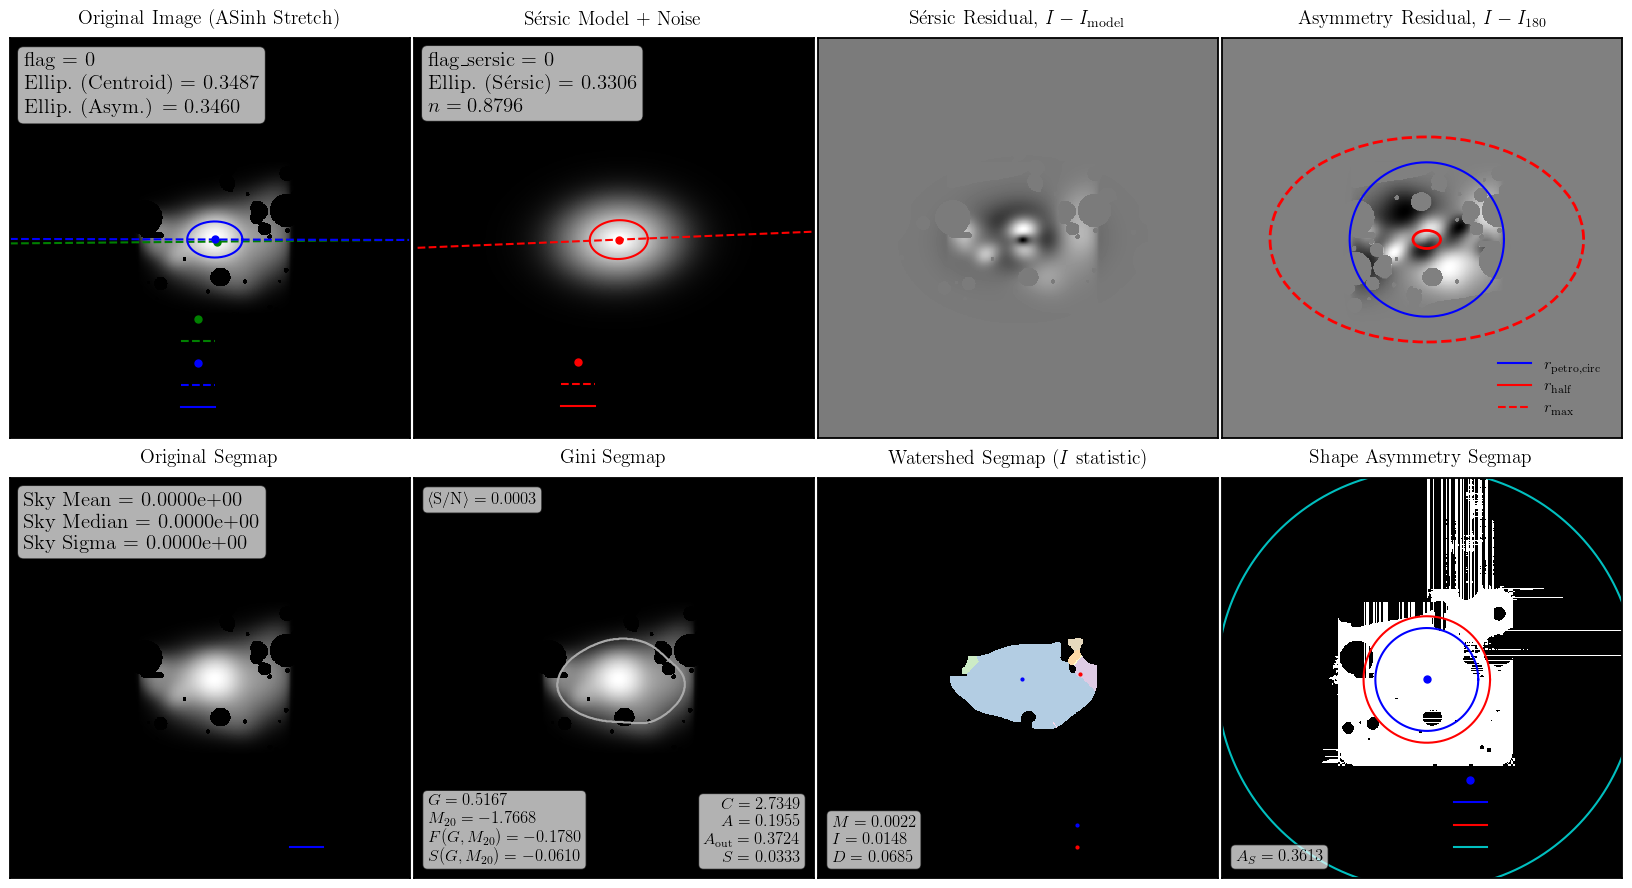

In [32]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [33]:
print(measurement['rhalf_circularized'] * 0.168, params_cat[
    params_cat['viz-id'] == ind]['rhalf_circularized'][0])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

6.697541728454144 10.123363294890986


7.044996940407507

In [30]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 1.028798351313437,
    'half_light_radius': 5.402173888566778},
   'shear_params': {'q': 0.6110458275533068,
    'beta': coord.Angle(1.2569557471007504, coord.radians)},
   'sed': array([0.48227494, 0.78764329, 1.        , 1.14666919])}],
 'imag': 19.235374805524145,
 'flux_fraction': [1.0],
 'ra': 150.23999749502534,
 'dec': 1.6820617760172785,
 'gmag': 20.02713806681768,
 'rmag': 19.494550856382407,
 'zmag': 19.086779447544068}

In [694]:
seg_meas_cat[seg_meas_cat['ID'] == ind]

<Table length=1>
  ID                  flux [4]                ...   flag  flag_sersic
int64                 float64                 ... float64   float64  
----- --------------------------------------- ... ------- -----------
 1500 318.63031005859375 .. 396.2188415527344 ...     0.0         0.0

In [695]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 1.0074991388458838,
    'half_light_radius': 5.724754136052598},
   'shear_params': {'q': 0.6742731205835168,
    'beta': coord.Angle(-0.18477464385138007, coord.radians)},
   'sed': array([0.66631199, 0.94356306, 1.        , 1.07988895])}],
 'imag': 20.110828239263128,
 'flux_fraction': [1.0],
 'ra': 210.48706793860302,
 'dec': -1.5467392145258536,
 'gmag': 20.551634164493027,
 'rmag': 20.173900911711083,
 'zmag': 20.027380498297934}

In [43]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.020304, 19.281012, 18.990501, 19.006485], dtype=float32)

In [437]:
measurement['SB_eff_avg'][0], params_cat[params_cat['viz-id'] == ind]['SB_eff_g'][0]

(27.329329, 27.562105696766316)

In [179]:
with open('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/mock_sample/failed_ind.txt', 'rb') as f:
    text = f.read().decode('ascii')
text = text.split(sep='\n')

In [178]:
import re

In [195]:
len([int(re.search("mock-(\d*)-trained-model-wavelet.df", tex).group(1)) for tex in text])

30

In [51]:
ind = 28
method = 'wavelet'
# method = 'vanilla'
with open(f'./Model/nsa_z002_004/nsa-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=True,
    show_mark=False, 
    show_loss=True)

FileNotFoundError: [Errno 2] No such file or directory: './Model/nsa_z002_004/nsa-28-trained-model-wavelet.df'